In [6]:
!pip install torch-geometric scikit-learn -q


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx




In [8]:
# Load dataset
file_path = "/content/drive/MyDrive/Datasets/synthetic_train_smote_v2.csv"
df = pd.read_csv(file_path)
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224596 entries, 0 to 224595
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Time                224596 non-null  float64
 1   Transaction_Amount  224596 non-null  float64
 2   feat1               224596 non-null  float64
 3   feat10              224596 non-null  float64
 4   feat11              224596 non-null  float64
 5   feat12              224596 non-null  float64
 6   feat13              224596 non-null  float64
 7   feat14              224596 non-null  float64
 8   feat15              224596 non-null  float64
 9   feat16              224596 non-null  float64
 10  feat17              224596 non-null  float64
 11  feat18              224596 non-null  float64
 12  feat19              224596 non-null  float64
 13  feat2               224596 non-null  float64
 14  feat20              224596 non-null  float64
 15  feat21              224596 non-nul

In [9]:
# Standardize features (excluding 'Time' and 'IsFraud')
scaler = StandardScaler()
features = scaler.fit_transform(df.iloc[:, 1:-1].values)
# Ensure the dataset has only 29 features
features = features[:, :-1]  # Remove the last column to make it 29 features


# Convert features and labels to tensors
node_features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(df["IsFraud"].values, dtype=torch.long)


In [10]:
import joblib
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved successfully as scaler.pkl") # If scaler.pkl is missing, this fails!


Scaler saved successfully as scaler.pkl


In [11]:
!pip install faiss-cpu




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 48.2 MB/s eta 0:00:00


In [12]:
import faiss

k = 10  # Number of nearest neighbors

# Convert node features to NumPy
features_np = node_features.numpy().astype(np.float32)

# Build FAISS index
index = faiss.IndexFlatL2(features_np.shape[1])  # L2 distance (Euclidean)
index.add(features_np)

# Find k nearest neighbors
_, knn_edges = index.search(features_np, k + 1)  # k+1 because the first neighbor is itself
src_nodes, dst_nodes = [], []
# Convert KNN edges to edge list format
knn_src_nodes, knn_dst_nodes = [], []
for i in range(len(knn_edges)):
    for j in knn_edges[i][1:]:  # Skip the first result (self-loop)
        knn_src_nodes.append(i)
        knn_dst_nodes.append(j)

# Combine with existing edges
src_nodes.extend(knn_src_nodes)
dst_nodes.extend(knn_dst_nodes)

# Convert to PyG format
edge_index = torch.tensor([src_nodes, dst_nodes], dtype=torch.long)
graph_data = Data(x=node_features, edge_index=edge_index, y=labels)
print(graph_data)
# Check final node degree
num_nodes = graph_data.num_nodes
num_edges = graph_data.num_edges
avg_degree = num_edges / num_nodes
print(f"Final Average Node Degree after KNN (FAISS): {avg_degree:.2f}")


Data(x=[224596, 28], edge_index=[2, 2245960], y=[224596])
Final Average Node Degree after KNN (FAISS): 10.00


In [13]:

import random
# Convert PyG graph to NetworkX format
G = to_networkx(graph_data, to_undirected=True)

# Select a random subset of nodes for visualization (e.g., 1000 nodes)
num_nodes_to_plot = 1000
subset_nodes = random.sample(list(G.nodes), min(num_nodes_to_plot, len(G.nodes)))


# Create a subgraph with selected nodes
subG = G.subgraph(subset_nodes)



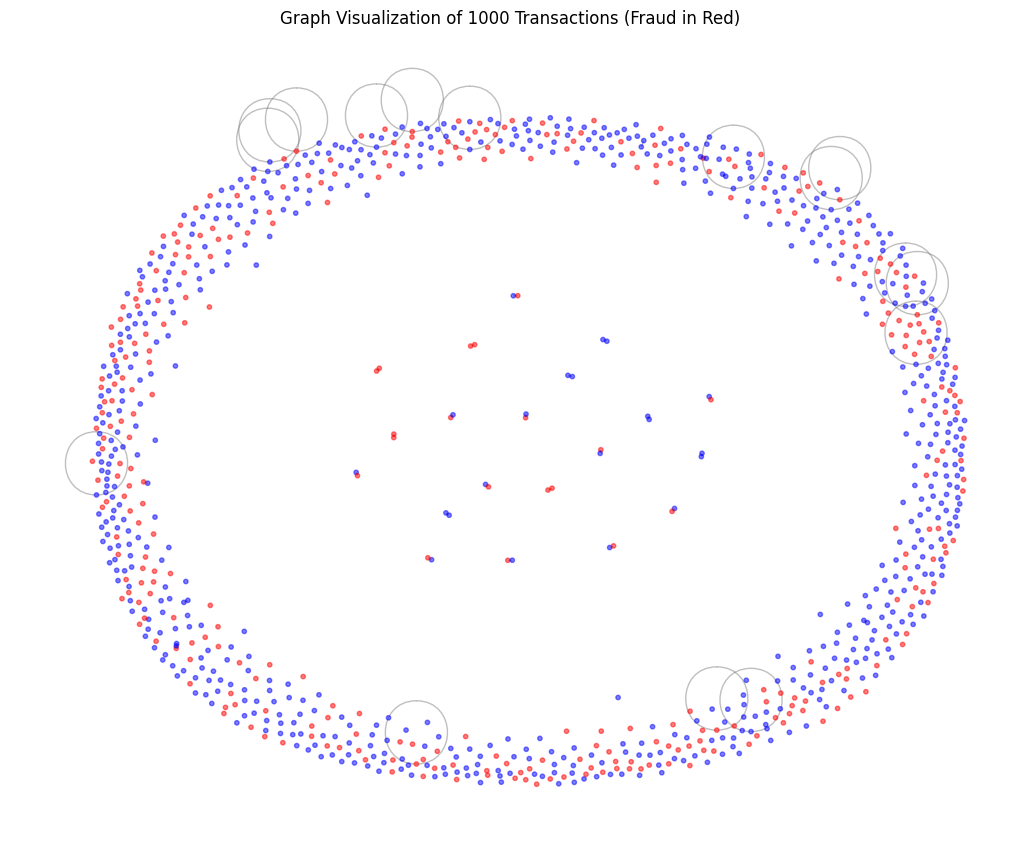

In [14]:
# Define node colors (red for fraud, blue for non-fraud)
node_colors = ["red" if labels[i].item() == 1 else "blue" for i in subset_nodes]

# Re-draw the graph with fraud marked
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subG, seed=42)
nx.draw(subG, pos, node_size=10, node_color=node_colors, edge_color="gray", alpha=0.5)
plt.title(f"Graph Visualization of {len(subset_nodes)} Transactions (Fraud in Red)")
plt.show()



In [15]:
from sklearn.model_selection import train_test_split

# Convert labels to NumPy for train_test_split
labels_np = labels.cpu().numpy()

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    node_features.numpy(), labels_np, np.arange(len(node_features)),
    test_size=0.2, stratify=labels_np, random_state=42
)

# Convert back to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create boolean masks
train_mask = torch.zeros(len(node_features), dtype=torch.bool)
test_mask = torch.zeros(len(node_features), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True



In [16]:
class FraudGNN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(FraudGNN, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_size)
        self.conv2 = SAGEConv(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x


In [17]:

model = FraudGNN(in_feats=node_features.shape[1], hidden_size=64, num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    logits = model(graph_data)  # Get model predictions
    loss = loss_fn(logits[train_mask], y_train)  # Use only training nodes
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.6866
Epoch 5, Loss: 0.6563
Epoch 10, Loss: 0.6437
Epoch 15, Loss: 0.6388
Epoch 20, Loss: 0.6390
Epoch 25, Loss: 0.6376
Epoch 30, Loss: 0.6373
Epoch 35, Loss: 0.6370
Epoch 40, Loss: 0.6367
Epoch 45, Loss: 0.6365


In [18]:
print("Feature shape:", node_features.shape[1])  # Check how many features are in the dataset


Feature shape: 28


In [19]:
# Save the GNN model (architecture and state_dict)
gnn_model_path = "/content/drive/MyDrive/Datasets/fraud_gnn_model.pth"
torch.save(model.state_dict(), gnn_model_path)

print(f"GNN model saved to {gnn_model_path}")

GNN model saved to /content/drive/MyDrive/Datasets/fraud_gnn_model.pth


In [20]:

with torch.no_grad():
    gnn_embeddings = model(graph_data).detach().cpu().numpy()

# Train Isolation Forest on training set embeddings
iso_forest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
iso_forest.fit(gnn_embeddings[train_idx])

# Predict fraud on test set
iso_preds = iso_forest.predict(gnn_embeddings[test_idx])
iso_preds = np.where(iso_preds == -1, 1, 0)

In [21]:
gnn_preds = model(graph_data).softmax(dim=1)[:, 1].detach().cpu().numpy()
gnn_preds = gnn_preds[test_idx]  # Keep only test set predictions

# Adjust fraud probability threshold (reduce false positives)
final_preds = (gnn_preds > 0.35) | (iso_preds == 1)  # Predict fraud if either method detects it

# Convert to integer labels (0 = Non-Fraud, 1 = Fraud)
final_preds = final_preds.astype(int)


In [22]:
import joblib

# Save the trained Isolation Forest model
iso_forest_model_path = "/content/drive/MyDrive/Datasets/iso_forest_model.pkl"
joblib.dump(iso_forest, iso_forest_model_path)

print(f"Isolation Forest model saved to {iso_forest_model_path}")

Isolation Forest model saved to /content/drive/MyDrive/Datasets/iso_forest_model.pkl


              precision    recall  f1-score   support

           0       0.73      0.89      0.80     29947
           1       0.60      0.35      0.44     14973

    accuracy                           0.71     44920
   macro avg       0.67      0.62      0.62     44920
weighted avg       0.69      0.71      0.68     44920



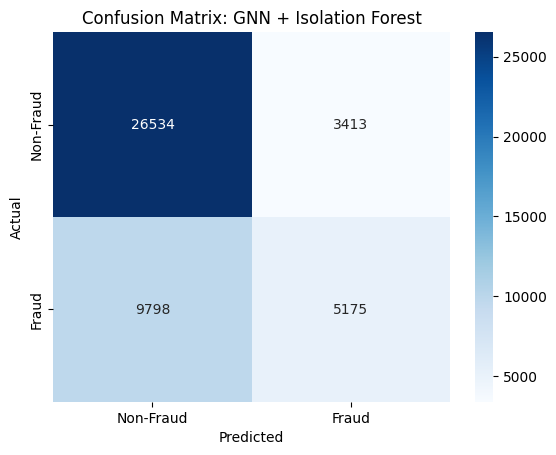

In [23]:
print(classification_report(y_test, final_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: GNN + Isolation Forest")
plt.show()

In [24]:
import torch

# Define the model architecture (same as during training)
model = FraudGNN(in_feats=node_features.shape[1], hidden_size=64, num_classes=2)

# Load the saved state_dict
gnn_model_path = "/content/drive/MyDrive/Datasets/fraud_gnn_model.pth"
model.load_state_dict(torch.load(gnn_model_path))

# Set the model to evaluation mode
model.eval()

print("GNN model loaded successfully!")



GNN model loaded successfully!


In [25]:
import joblib

iso_forest_path = "/content/drive/MyDrive/Datasets/iso_forest_model.pkl"
iso_forest = joblib.load(iso_forest_path)

print("Isolation Forest model loaded successfully!")



Isolation Forest model loaded successfully!


In [26]:
# Ensure you use the same `graph_data` used during training
with torch.no_grad():
    gnn_embeddings = model(graph_data).detach().cpu().numpy()

# Use Isolation Forest for fraud detection
iso_preds = iso_forest.predict(gnn_embeddings)
iso_preds = np.where(iso_preds == -1, 1, 0)  # Convert -1 (anomaly) to 1 (fraud)

# Get GNN fraud probabilities
gnn_probs = model(graph_data).softmax(dim=1)[:, 1].detach().cpu().numpy()

# Final prediction (threshold-based + Isolation Forest)
final_preds = (gnn_probs > 0.35) | (iso_preds == 1)  # Predict fraud if either method detects it
final_preds = final_preds.astype(int)

print("Predictions completed!")


Predictions completed!


In [27]:
# Convert predictions to a DataFrame with numerical and text labels
df_predictions = pd.DataFrame({
    "Transaction_ID": df.index,  # Use transaction index or ID if available
    "GNN_Probability": gnn_probs,
    "Isolation_Forest_Prediction": iso_preds,
    "Final_Prediction": final_preds.astype(int),  # 0 = Non-Fraud, 1 = Fraud
    "Fraud_Label": ["Fraud" if pred == 1 else "Non-Fraud" for pred in final_preds]  # Text label
})

# Show sample predictions
print(df_predictions.head(10))




   Transaction_ID  GNN_Probability  Isolation_Forest_Prediction  \
0               0         0.344142                            0   
1               1         0.348576                            0   
2               2         0.343534                            0   
3               3         0.345557                            0   
4               4         0.336916                            0   
5               5         0.311850                            0   
6               6         0.312553                            0   
7               7         0.368297                            0   
8               8         0.353616                            0   
9               9         0.344820                            0   

   Final_Prediction Fraud_Label  
0                 0   Non-Fraud  
1                 0   Non-Fraud  
2                 0   Non-Fraud  
3                 0   Non-Fraud  
4                 0   Non-Fraud  
5                 0   Non-Fraud  
6                 0   No